# Sentiment Analysis using Logistic Regression & MLFlow exp

## Введение

В этом ноутбуке мы используем датасет Amazon Review, препроцессинг данных, трансформацию типа Bag of Words (BoW)

В дальнейшем производим тренировку на Логистической Регрессии. 

In [1]:
import pandas as pd
import mlflow
import numpy as np
import re
import nltk
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from numpy import triu
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/anatoly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anatoly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Preprocessing function
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    # Removing punctuation
    tokens = [token for token in tokens if re.match(r'^\w+$', token)]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

## Импорт данных. Величина датасета - 500 000 (для тренировки)

In [3]:
df_original_train = pd.read_csv("/home/anatoly/Рабочий стол/MLOps/example/Amazon review/amazon_review_polarity_csv/train.csv",header=None, names=("polarity", "title", "text"))
df_train = df_original_train.sample(500000)

In [4]:
df_original_test = pd.read_csv("/home/anatoly/Рабочий стол/MLOps/example/Amazon review/amazon_review_polarity_csv/test.csv", header=None, names=("polarity", "title", "text"))
df_test = df_original_test

In [5]:
df_train.head()

polarity                           title  \
1174833         1          havent received it yet   
2101937         1                   cheap plastic   
2761732         1  LaserJet 1200 - Poor Condition   
2529304         1  One of the worst PS2 game ever   
1774870         1             dangerous collapsed   

                                                      text  
1174833  I am sure that to review something I havent br...  
2101937  did not survive the first use. I would not rec...  
2761732  This product is missing the clear paper input....  
2529304  Overrated and boring game is a real waste of m...  
1774870  I have four kids under the age of five. I just...

In [6]:
df_test.head()

polarity                                              title  \
0         2                                           Great CD   
1         2  One of the best game music soundtracks - for a...   
2         1                   Batteries died within a year ...   
3         2              works fine, but Maha Energy is better   
4         2                       Great for the non-audiophile   

                                                text  
0  My lovely Pat has one of the GREAT voices of h...  
1  Despite the fact that I have only played a sma...  
2  I bought this charger in Jul 2003 and it worke...  
3  Check out Maha Energy's website. Their Powerex...  
4  Reviewed quite a bit of the combo players and ...

In [7]:
df_test.shape

(400000, 3)

## Data Pre-Processing

In [8]:
df_train["clean_text"] = df_train["title"] + " " + df_train["text"]
df_train["clean_text"] = df_train["clean_text"].apply(preprocess_text)
df_train.head()

polarity                           title  \
1174833         1          havent received it yet   
2101937         1                   cheap plastic   
2761732         1  LaserJet 1200 - Poor Condition   
2529304         1  One of the worst PS2 game ever   
1774870         1             dangerous collapsed   

                                                      text  \
1174833  I am sure that to review something I havent br...   
2101937  did not survive the first use. I would not rec...   
2761732  This product is missing the clear paper input....   
2529304  Overrated and boring game is a real waste of m...   
1774870  I have four kids under the age of five. I just...   

                                                clean_text  
1174833  havent receiv yet sure review someth havent br...  
2101937  cheap plastic surviv first use would recommend...  
2761732  laserjet 1200 poor condit product miss clear p...  
2529304  one worst ps2 game ever overr bore game real w...  
1774870  danger collaps four kid age five got walk repl...

In [9]:
df_test["clean_text"] = df_test["title"] + " " + df_test["text"]
df_test["clean_text"] = df_test["clean_text"].apply(preprocess_text)
df_test.head()

polarity                                              title  \
0         2                                           Great CD   
1         2  One of the best game music soundtracks - for a...   
2         1                   Batteries died within a year ...   
3         2              works fine, but Maha Energy is better   
4         2                       Great for the non-audiophile   

                                                text  \
0  My lovely Pat has one of the GREAT voices of h...   
1  Despite the fact that I have only played a sma...   
2  I bought this charger in Jul 2003 and it worke...   
3  Check out Maha Energy's website. Their Powerex...   
4  Reviewed quite a bit of the combo players and ...   

                                          clean_text  
0  great cd love pat one great voic gener listen ...  
1  one best game music soundtrack game realli pla...  
2  batteri die within year bought charger jul 200...  
3  work fine maha energi better check maha energi...  
4  great review quit bit combo player hesit due u...

## Split X & Y

In [10]:
X_train = df_train["clean_text"]
y_train = df_train["polarity"]

X_test = df_test["clean_text"]
y_test = df_test["polarity"]

### BoW: Bag of Words

BoW is a simple text representation technique in natural language processing where a document is represented as a collection of words, disregarding grammar and word order, focusing solely on word frequency.

In [11]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

## Logistic Regression Model Training

### LR using BoW

In [12]:
lr_bow = LogisticRegression(max_iter=X_train_bow.shape[0])
lr_bow.fit(X_train_bow, y_train)

LogisticRegression(max_iter=500000)

In [13]:
y_pred_bow = lr_bow.predict(X_test_bow)

In [14]:
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print("Logistic Regression with BoW Accuracy:", accuracy_bow)
print("Classification Report with BoW:")
print(classification_report(y_test, y_pred_bow))

Logistic Regression with BoW Accuracy: 0.8805325
Classification Report with BoW:
              precision    recall  f1-score   support

           1       0.89      0.87      0.88    200000
           2       0.87      0.89      0.88    200000

    accuracy                           0.88    400000
   macro avg       0.88      0.88      0.88    400000
weighted avg       0.88      0.88      0.88    400000



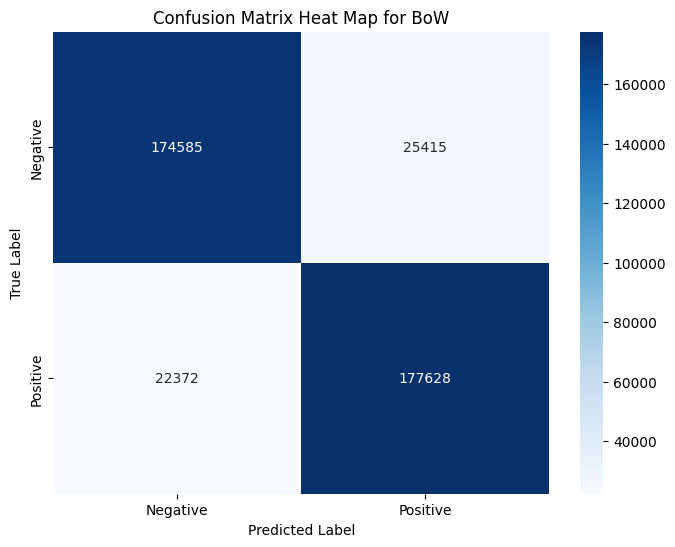

In [15]:
cm_bow = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heat Map for BoW')
plt.show()

2024/05/19 12:05:29 INFO mlflow.tracking.fluent: Experiment with name 'LR_bow' does not exist. Creating a new experiment.
2024/05/19 12:05:29 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTH

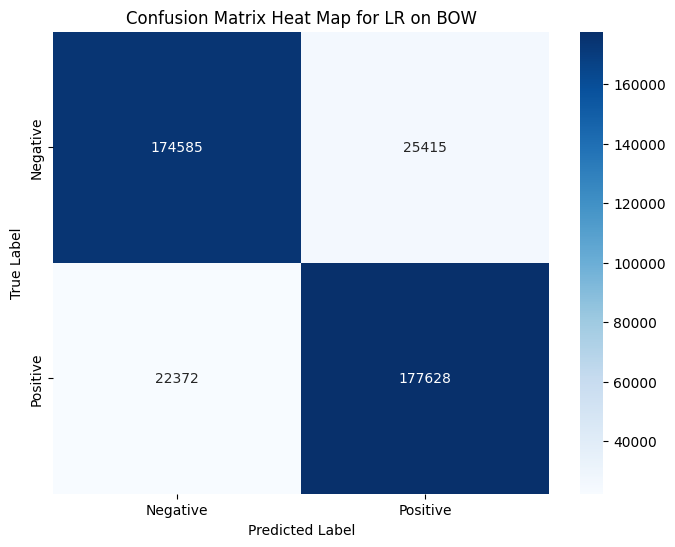

In [16]:
# Подключение к серверу MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")
# Зафиксируем текущее название эксперимента
embeddings_experiment = mlflow.set_experiment("LR_bow")

# Зафиксируем название текущего запуска, если не фиксировать, оно автосгенерируется
bow_run_name = "lr_bow"
random_state = 42
lr_bow_params = {
    "max_iter": X_train_bow.shape[0]
}

with mlflow.start_run(run_name=bow_run_name) as run:
    model_params = {
        "multi_class": "multinomial",
        "solver": "saga",
        "random_state": random_state,
    }
    lr_bow = LogisticRegression(max_iter=X_train_bow.shape[0])
    lr_bow.fit(X_train_bow, y_train)
    predicts = lr_bow.predict(X_test_bow)
    report = classification_report(y_test, y_pred_bow, output_dict=True)

    # логирование метрик из classification report
    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)
    
    # Логирование параметров модели
    mlflow.log_params(lr_bow_params) 
    mlflow.log_params(model_params)

    # Логирование целой модели для переиспользование
    mlflow.sklearn.log_model(
        sk_model=lr_bow, 
        # input_example=test_features[:10], 
        artifact_path=f"mlflow/{bow_run_name}/model"
    )
    
     # Получение confusion matrix на два класса


    bow_tfidf = confusion_matrix(y_test, y_pred_bow)
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(bow_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heat Map for LR on BOW')
    plt.show()
    
    # Логирование фигур или целых артефактов
    mlflow.log_figure(fig, f'{bow_run_name}_confusion_matrix.png')